<a href="https://colab.research.google.com/github/hxchoongh/Machine_Learning/blob/main/tf_hub_CIFAR10_VGG16_TPU256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Connect to the TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU:', tpu.master())
except ValueError:
    print('No TPU found, using default strategy')
    strategy = tf.distribute.get_strategy()  # Default strategy


Running on TPU: 


In [3]:
# Load the CIFAR-10 dataset
# CIFAR-10 consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.
# Split into 50,000 training images and 10,000 test images.
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
# import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [5]:
x_train, x_val, y_train, y_val = train_test_split(
  train_images, train_labels , random_state=104,test_size=0.25, shuffle=True)

In [6]:

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Resizing


# Define the resizing layer (to 224x224)
resize_layer = Resizing(224, 224)

# Example: Resizing a single CIFAR-10 image
image = train_images[0]  # A single 32x32x3 image from CIFAR-10

# Resize the image using the resizing layer
image_resized = resize_layer(image)

# Apply VGG16 preprocessing (this will handle BGR conversion and mean subtraction)
image_preprocessed = preprocess_input(image_resized)

print(image_preprocessed.shape)  # Output: (224, 224, 3)

(224, 224, 3)


In [7]:
# Resize and preprocess the entire dataset
x_train_resized = resize_layer(x_train)  # Resizing all training images to 224x224
x_test_resized = resize_layer(test_images)    # Resizing all test images to 224x224
x_val_resized = resize_layer(x_val) # Resizing all val images to 224x224
y_train = y_train
y_test = test_labels

# Apply VGG16 preprocessing to the resized dataset
x_train_preprocessed = preprocess_input(x_train_resized) #rgb becomes bgr, centered to mean
x_test_preprocessed = preprocess_input(x_test_resized)
x_val_preprocessed = preprocess_input(x_val_resized)

print(x_train_preprocessed.shape)  # Output: (37500, 224, 224, 3)
print(x_test_preprocessed.shape)   # Output: (10000, 224, 224, 3)
print(x_val_preprocessed.shape) # Output: (12500, 224, 224, 3)

(37500, 224, 224, 3)
(10000, 224, 224, 3)
(12500, 224, 224, 3)


In [8]:
# Define the class names for CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
# Display some of the training images
def plot_sample_images(images, labels, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        # The CIFAR labels are arrays, so we need the first element
        plt.xlabel(class_names[labels[i][0]])
    plt.show()

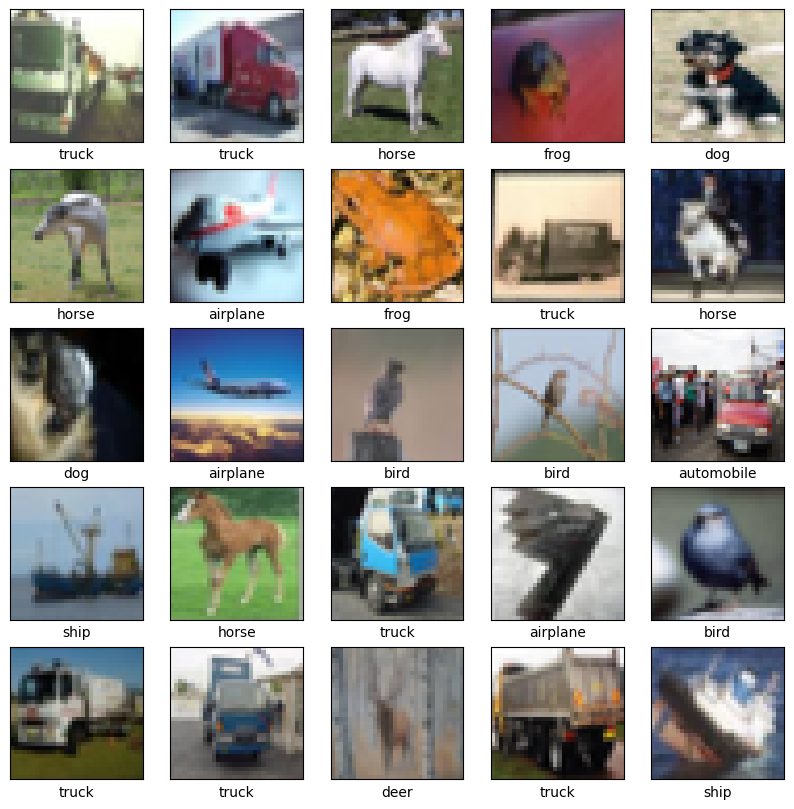

In [10]:
# Visualizing some sample images from the dataset
plot_sample_images(x_train, y_train, class_names)

In [11]:
print(y_train.shape)

(37500, 1)


In [12]:
# If y_train and y_test are in the shape (500, 1), convert them to (500,)
y_train = y_train.reshape(-1)  # Reshape to 1D array
y_val = y_val.reshape(-1)
# y_test = y_test.reshape(-1)    # Reshape to 1D array

# Verify shapes
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(37500,)
(12500,)
(10000, 1)


In [13]:
# Model definition must be inside the strategy.scope()
with strategy.scope():
    # Load pre-trained VGG16 with ImageNet weights, excluding the top layers
    base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Create the classification model using Sequential
    model = tf.keras.Sequential([
        base_model,                   # Pre-trained VGG16 model
        tf.keras.layers.GlobalAveragePooling2D(),     # Global average pooling, Dimensionality reduction
        tf.keras.layers.Dense(10, activation='softmax')  # Classification layer for 10 classes, Softmax converts to values between 0 to 1, use of exponential functions create probabilities that can be ranked
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Print model summary (optional)
model.summary()


# # Build the VGG16 model
# #base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False  # Freeze the base model

# # Add classification layers
# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
# ])

# Enable eager execution for debugging (if needed). for TPU this must be set to False
# tf.config.run_functions_eagerly(False)

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_preprocessed, y_train)).shuffle(500).batch(256).prefetch(buffer_size=AUTOTUNE) # Batch Must be multiples of 128
test_dataset = tf.data.Dataset.from_tensor_slices((x_val_preprocessed, y_val)).shuffle(125).batch(256).prefetch(buffer_size=AUTOTUNE)

# history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)
# Train the model
#history = model.fit(x_train_preprocessed, y_train, epochs=10, validation_split=0.2)
# Take a small subset of your data
# x_train_subset = x_train_preprocessed[:1000]
# y_train_subset = y_train[:1000]
#x_train_subset = x_train_preprocessed



#history = model.fit(x_train_subset, y_train, epochs=10, batch_size=128,validation_split=0.2)

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 14719818 (56.15 MB)
Trainable params: 5130 (20.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/20
147/147 [==============================] - 63s 379ms/step - loss: 1.3939 - accuracy: 0.5831 - val_loss: 0.7628 - val_accuracy: 0.7471


In [14]:
# We can save our model with:
model.save('model.keras')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model.keras')

In [15]:
# Function to plot training and validation accuracy/loss over epochs
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

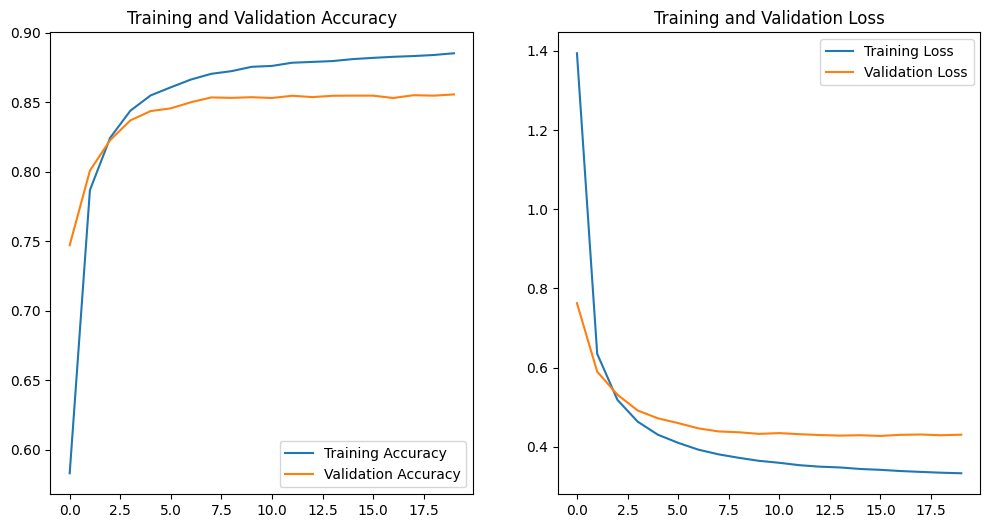

In [16]:
# Visualize training results
plot_training_history(history)

In [17]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test_preprocessed, y_test.reshape(-1))
print(f"Test accuracy: {test_acc}")

313/313 [==============================] - 16s 37ms/step - loss: 0.4439 - accuracy: 0.8514
Test accuracy: 0.8514000177383423


In [18]:
# Make predictions on the test set
predictions = model.predict(x_test_preprocessed)

313/313 [==============================] - 16s 35ms/step


In [19]:
# Function to display images with predictions
def plot_image_predictions(images, predictions, labels, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        predicted_label = np.argmax(predictions[i])
        true_label = labels[i][0]
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel(f"{class_names[predicted_label]} ({class_names[true_label]})", color=color)
    plt.show()

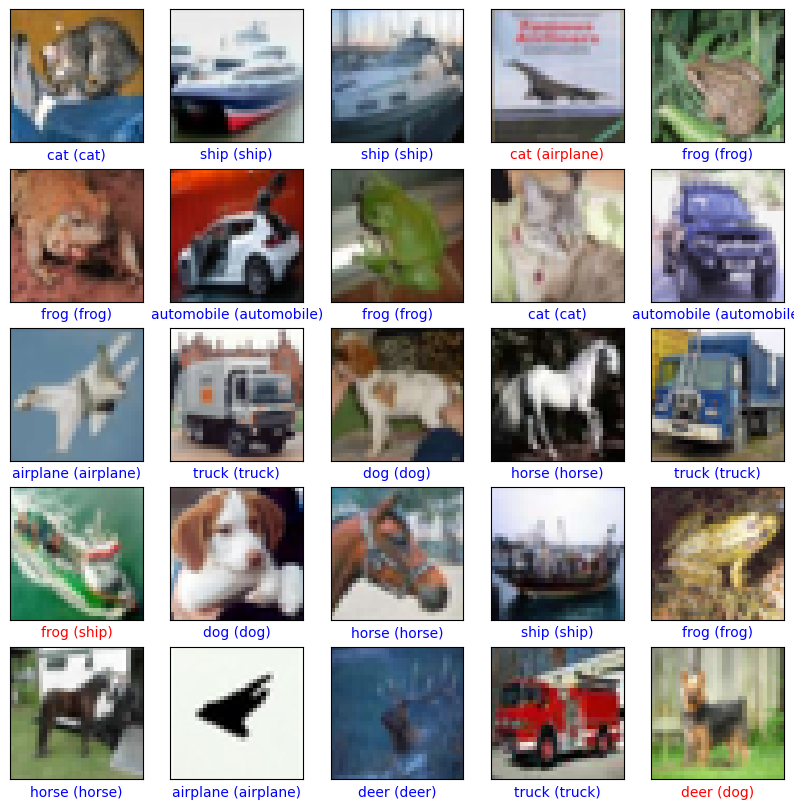

In [20]:
# Visualizing predictions
plot_image_predictions(test_images, predictions,y_test, class_names)